# Lecture 03 : Linear and Logistic Regression

## Linear Regression with tf.data
same contents, but different style with [Lec03_Linear Regression with tf.data.ipynb](https://nbviewer.jupyter.org/github/aisolab/CS20/blob/master/Lec03_Linear%20and%20Logistic%20Regression/Lec03_Linear%20Regression%20with%20tf.data.ipynb)

* Creating the input pipeline with `tf.data`
* Using `eager execution`  

**Reference**

* https://jhui.github.io/2017/11/21/TensorFlow-Importing-data/
* https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428
* https://stackoverflow.com/questions/47356764/how-to-use-tensorflow-dataset-api-with-training-and-validation-sets

### Setup

In [2]:
from __future__ import absolute_import, division, print_function
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint
%matplotlib inline

print(tf.__version__)
tf.enable_eager_execution()

1.13.2


### Build input pipeline

In [3]:
train_dir = os.listdir('example_with_data/train_dir/')
train_dir = list(map(lambda path : 'example_with_data/train_dir/' + path, train_dir))
pprint(train_dir, compact = True)

['example_with_data/train_dir/birth_life_2010_tr_1.txt',
 'example_with_data/train_dir/birth_life_2010_tr_10.txt',
 'example_with_data/train_dir/birth_life_2010_tr_11.txt',
 'example_with_data/train_dir/birth_life_2010_tr_12.txt',
 'example_with_data/train_dir/birth_life_2010_tr_13.txt',
 'example_with_data/train_dir/birth_life_2010_tr_14.txt',
 'example_with_data/train_dir/birth_life_2010_tr_2.txt',
 'example_with_data/train_dir/birth_life_2010_tr_3.txt',
 'example_with_data/train_dir/birth_life_2010_tr_4.txt',
 'example_with_data/train_dir/birth_life_2010_tr_5.txt',
 'example_with_data/train_dir/birth_life_2010_tr_6.txt',
 'example_with_data/train_dir/birth_life_2010_tr_7.txt',
 'example_with_data/train_dir/birth_life_2010_tr_8.txt',
 'example_with_data/train_dir/birth_life_2010_tr_9.txt']


In [5]:
val_dir = 'example_with_data/val_dir/birth_life_2010_val.txt'
pprint(val_dir)

'example_with_data/val_dir/birth_life_2010_val.txt'


In [6]:
# hyper parameters
epochs = 100
batch_size = 8

In [7]:
# datasets construction
# for training dataset
tr_dataset = tf.data.TextLineDataset(filenames = train_dir)
tr_dataset = tr_dataset.map(lambda record : tf.decode_csv(records = record,
                                                          record_defaults = [[''],[.0],[.0]],
                                                          field_delim = '\t')[1:])
tr_dataset = tr_dataset.shuffle(200)
tr_dataset = tr_dataset.batch(batch_size = batch_size)

# for validation dataset
val_dataset = tf.data.TextLineDataset(filenames = val_dir)
val_dataset = val_dataset.map(lambda record : tf.decode_csv(records = record,
                                                          record_defaults = [[''],[.0],[.0]],
                                                          field_delim = '\t')[1:])
val_dataset = val_dataset.batch(batch_size = batch_size)

### Define the graph of Simple Linear Regression

In [8]:
# create weight and bias, initialized to 0 
w = tf.Variable(initial_value=tf.constant(.0), name='weight')
b = tf.Variable(initial_value=tf.constant(.0), name='bias')

# construct model to predict Y
def model(x):
    yhat = x * w + b
    return yhat

# use the square error as loss function
def loss_fn(model, x, y):
    loss = tf.reduce_mean(tf.square(y - model(x)))
    return loss 

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)

### Training

In [9]:
# create writer for tensorboard
logdir = '../graphs/lecture03/linreg_mse_with_tf_data_de/'
summary_writer = tf.contrib.summary.create_file_writer(logdir=logdir)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [10]:
'''
# hyper parameters
epochs = 100
batch_size = 8
'''
global_step = tf.train.get_or_create_global_step()
tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    with summary_writer.as_default(), tf.contrib.summary.always_record_summaries(): # for tensorboard
        # for training
        for x_mb, y_mb in tr_dataset:
            with tf.GradientTape() as tape:
                tr_loss = loss_fn(model=model, x=x_mb, y=y_mb)
            tf.contrib.summary.scalar(name='tr_loss', tensor=tr_loss)
            avg_tr_loss += tr_loss
            tr_step +=1
            
            grads = tape.gradient(target=tr_loss, sources=[w, b])
            opt.apply_gradients(grads_and_vars=zip(grads, [w,b]))
        else:
            avg_tr_loss /= tr_step
            tr_loss_hist.append(avg_tr_loss)
        # for validation
        for x_mb, y_mb in val_dataset:
            val_loss = loss_fn(model=model, x=x_mb, y=y_mb)
            tf.contrib.summary.scalar(name='val_loss', tensor=val_loss)
            avg_val_loss += val_loss
            val_step += 1
        else:
            avg_val_loss /= val_step
            val_loss_hist.append(avg_val_loss)
    
    if (epoch + 1) % 10 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

Instructions for updating:
Colocations handled automatically by placer.
epoch :  10, tr_loss : 422.364, val_loss : 392.151
epoch :  20, tr_loss : 134.775, val_loss : 135.258
epoch :  30, tr_loss : 61.505, val_loss : 59.145
epoch :  40, tr_loss : 41.030, val_loss : 43.191
epoch :  50, tr_loss : 36.358, val_loss : 38.932
epoch :  60, tr_loss : 34.063, val_loss : 38.141
epoch :  70, tr_loss : 36.006, val_loss : 38.185
epoch :  80, tr_loss : 34.322, val_loss : 38.344
epoch :  90, tr_loss : 33.530, val_loss : 38.000
epoch : 100, tr_loss : 34.908, val_loss : 37.867


### Visualization

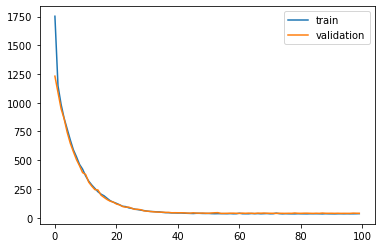

In [11]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

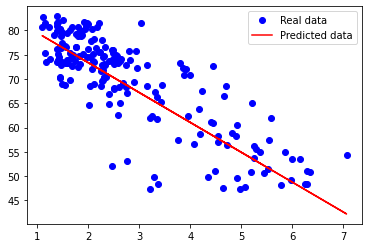

In [13]:
data = pd.read_table('example_with_placeholder/birth_life_2010.txt') # loading data for Visualization
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w + b, 'r', label='Predicted data')
plt.legend()